## Notebook to compare the different explainability methods for Biomining

In [1]:
import sys
from pathlib import Path
import os 

project_root = Path.cwd().parents[1]  
sys.path.append(str(project_root))
os.chdir(project_root)

In [2]:
from explainability.explaination_config import ExplainationConfig
config = ExplainationConfig(
    paper="biomining",
)
feature_names = config.feature_names

In [3]:
from explainability.shapley.utils import load_shap_data
from explainability.am.load_results import load_am_results_by_cell_line
import numpy as np
import torch

shap_values, inputs, feature_names, indices = load_shap_data("biomining")
print(shap_values.shape)

SAVE_PATH = "explainability/ig/results/biomining_integrated_gradients_mean.pt"
all_attributions = torch.load(SAVE_PATH, weights_only=False)
ig_values = all_attributions.squeeze(axis=1) 
ig_values = ig_values.detach().cpu().numpy()
print(ig_values.shape)

lrp_values = np.load("explainability/lrp/results/biomining_subsample_False/relevances.npy")
print(lrp_values.shape)

am_prototype = load_am_results_by_cell_line(paper ="biomining", cell_line="prototypeAM", regularization="l2_input")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


(32204, 33)
(32188, 33)
(32204, 33)


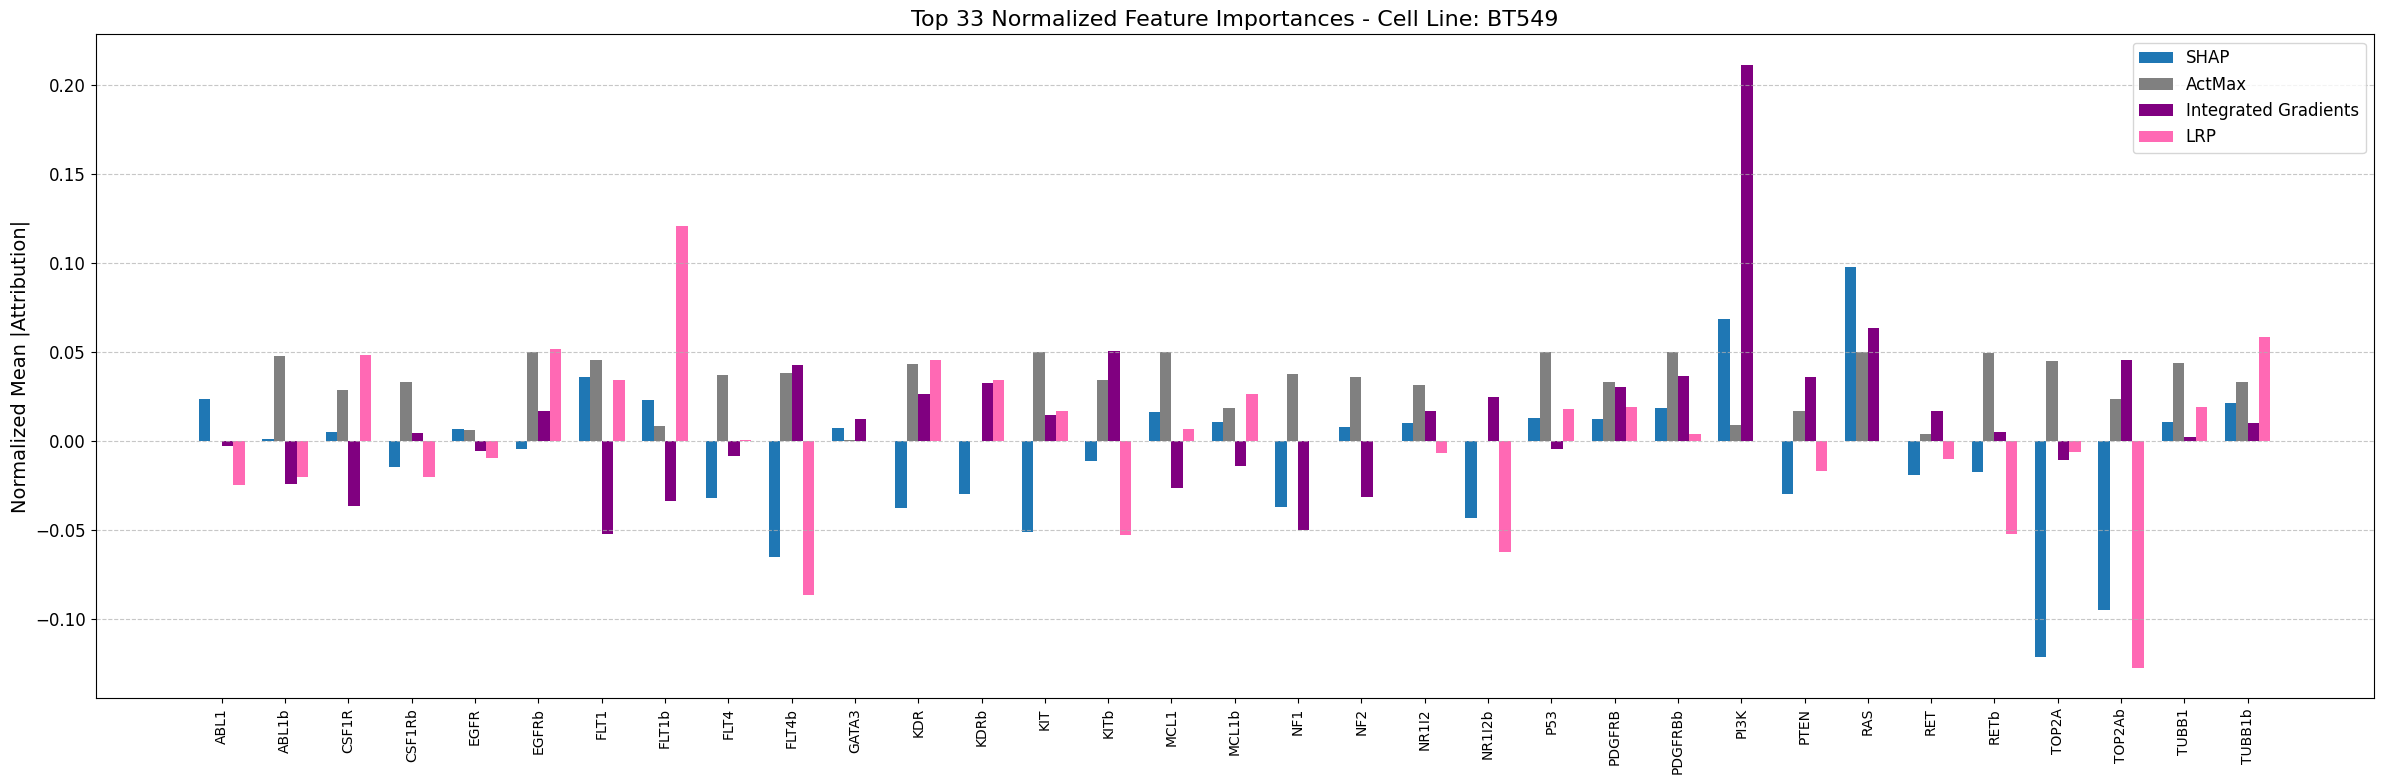

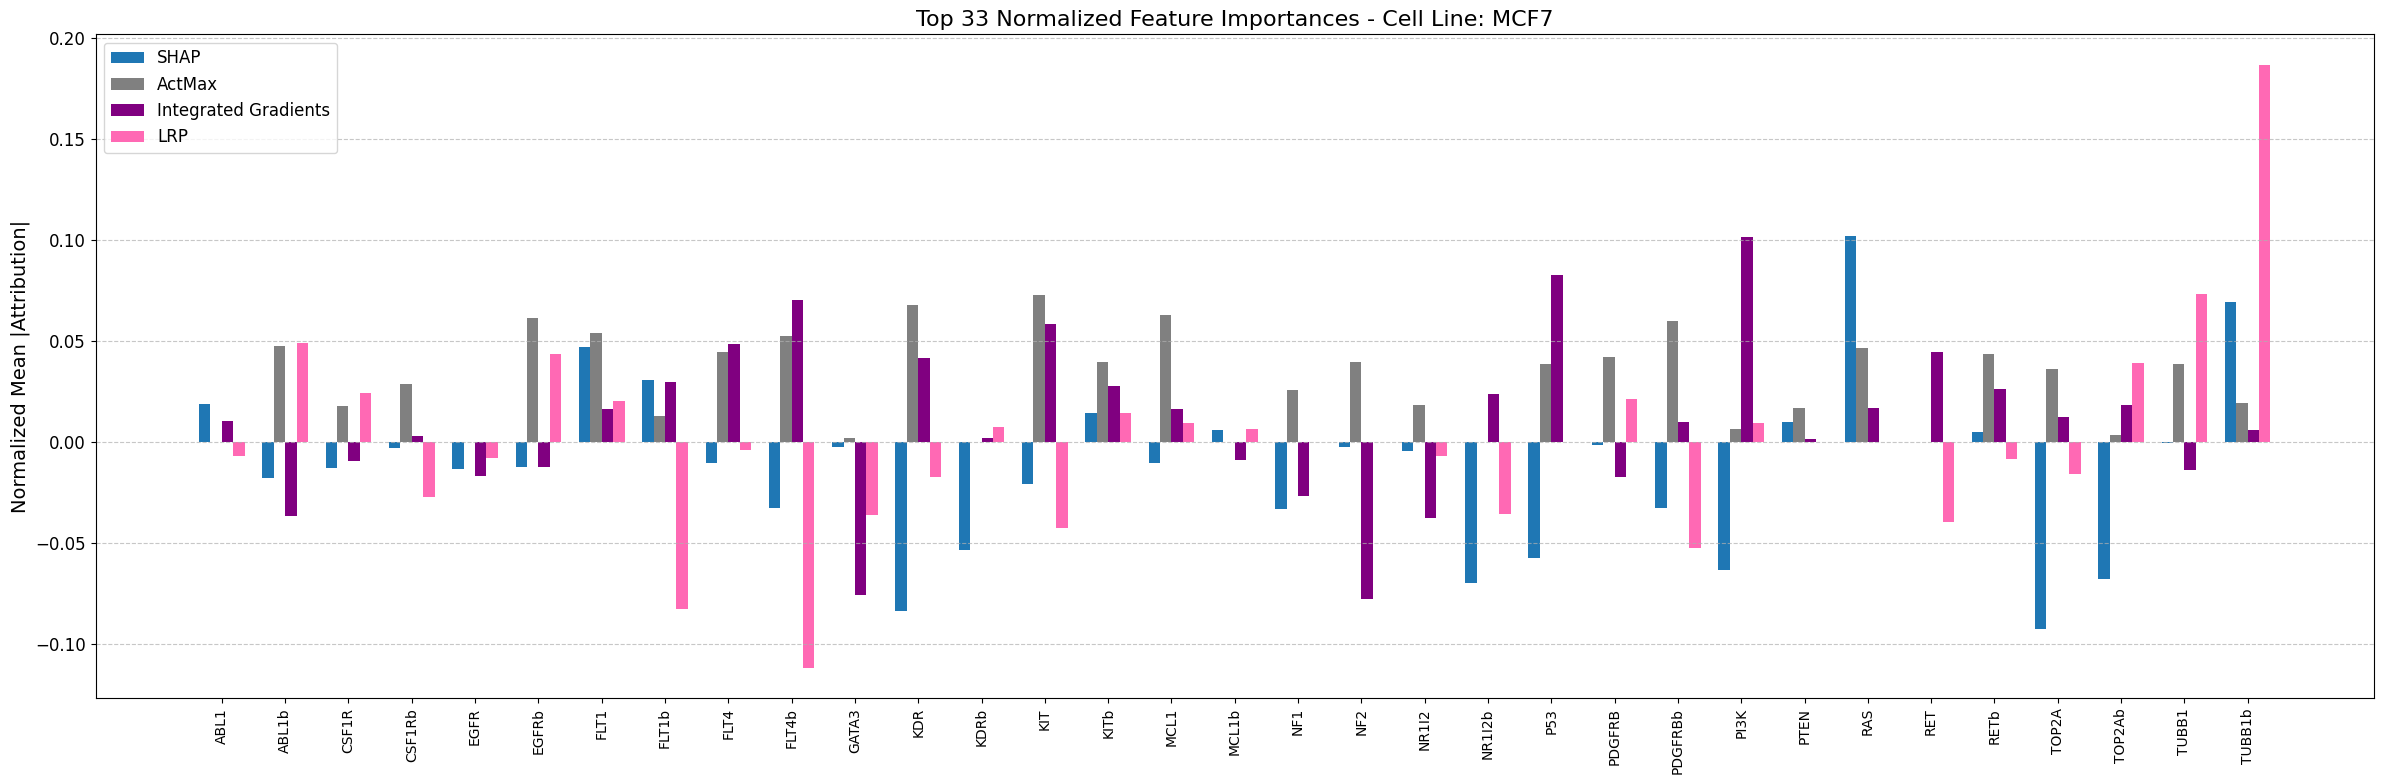

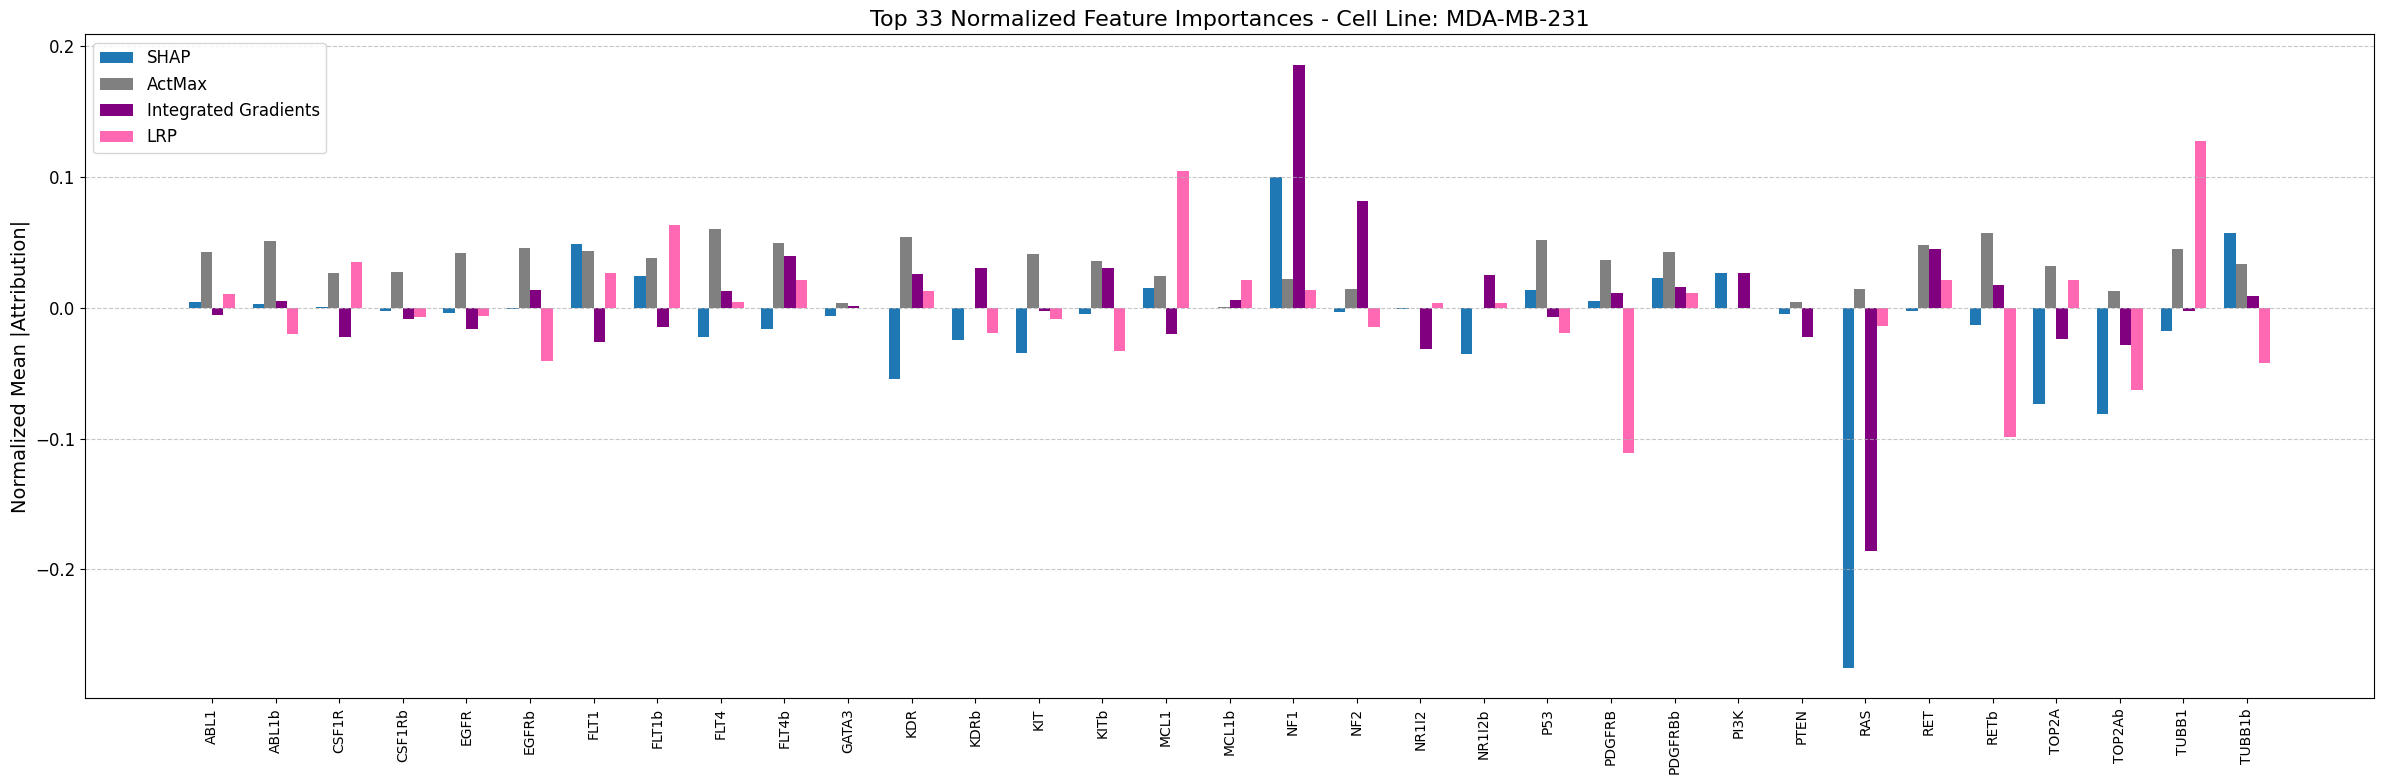

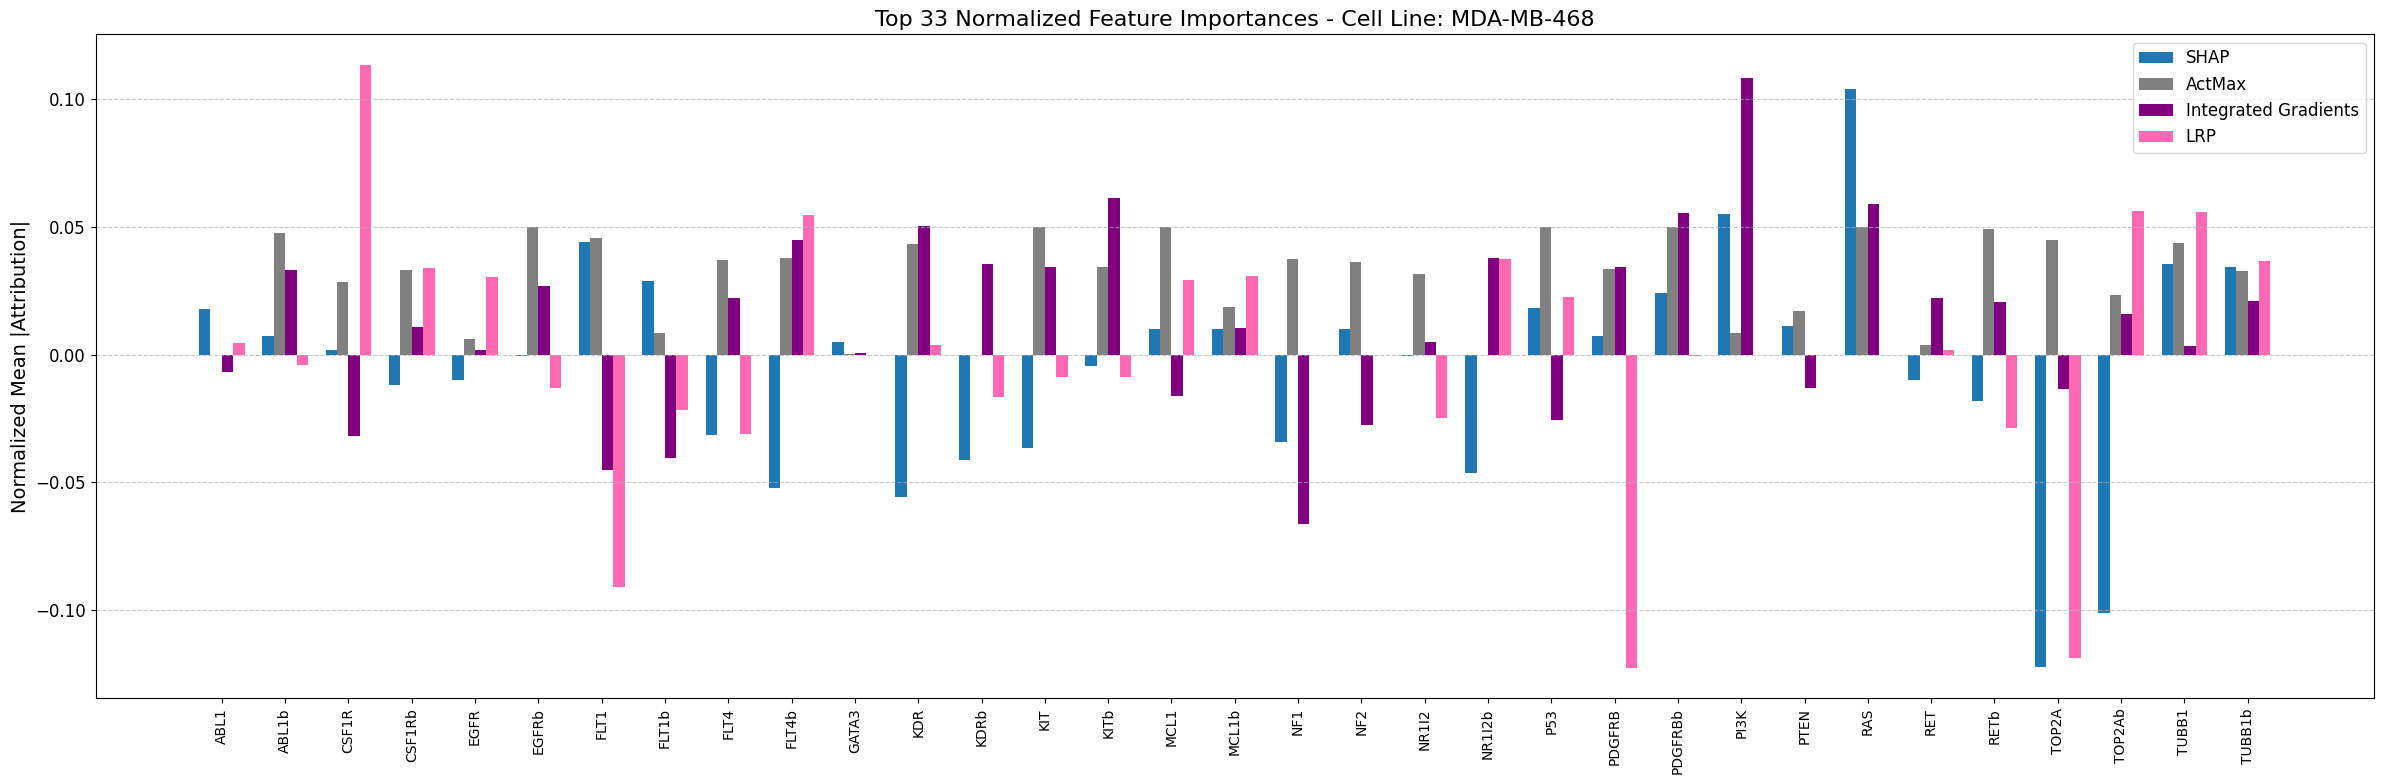

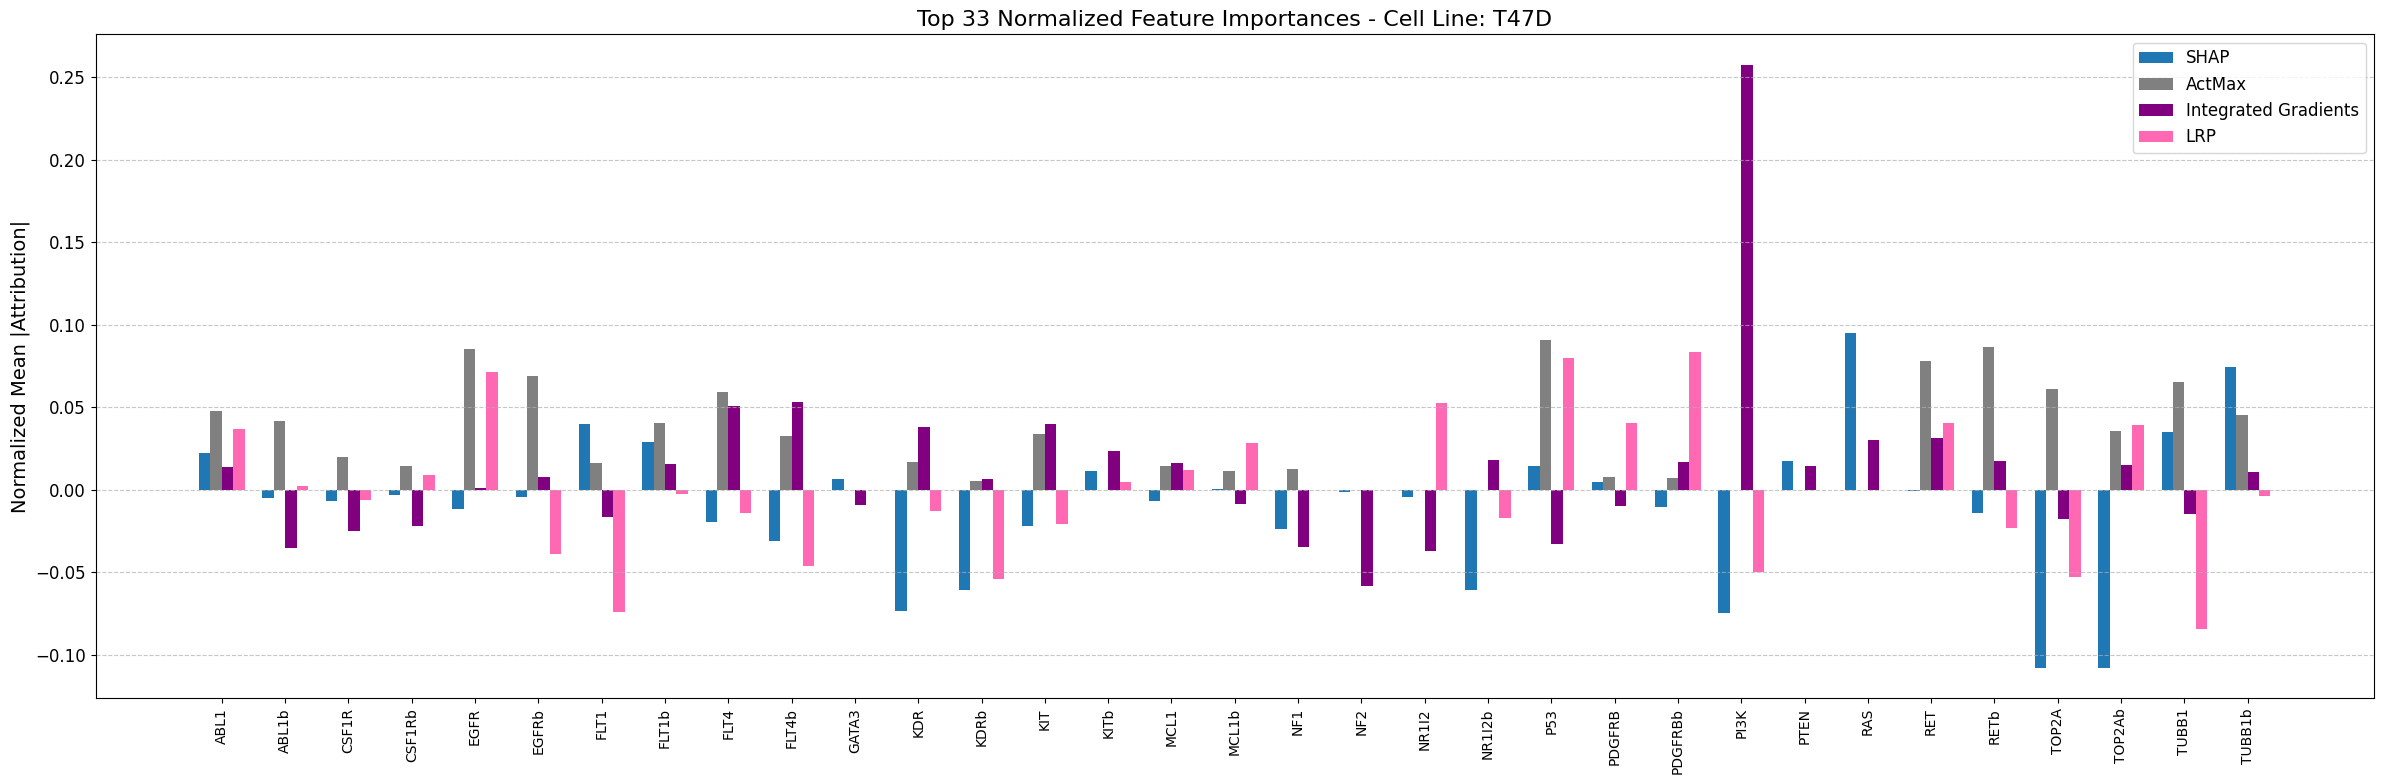

In [35]:
from explainability.data_utils import load_biomining_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def normalize_and_rescale_for_indices(attributions, indices):
    mean_vals = np.mean(attributions[indices], axis=0)
    mean_abs = np.abs(mean_vals)
    normed = mean_abs / np.sum(mean_abs)
    return normed / np.max(normed)

def plot_feature_importance_by_cell_line(shap_values, lrp_values, ig_values, feature_names, top_n=33):
    cell_lines_test = load_biomining_cell_line_data(split='test')
    cell_lines_test = np.concatenate([cell_lines_test, cell_lines_test], axis=0)
    cell_lines_train = load_biomining_cell_line_data(split='train')

    unique_test_cell_lines = np.unique(cell_lines_test)

    for cell_line in unique_test_cell_lines:
        shap_idx = np.where(cell_lines_test == cell_line)[0]
        lrp_idx = shap_idx
        ig_idx = np.where(cell_lines_train == cell_line)[0]

        am_vector = load_am_results_by_cell_line(
            paper="biomining",
            cell_line=cell_line,
            regularization="l2_input"
        )
        shap_imp = np.mean(shap_values[shap_idx], axis=0)
        lrp_imp = np.mean(lrp_values[lrp_idx], axis=0)
        ig_imp = np.mean(ig_values[ig_idx], axis=0)
        am_norm = am_vector

        # normalize all so their AUC = 1
        shap_imp /= np.sum(np.abs(shap_imp))
        lrp_imp /= np.sum(np.abs(lrp_imp))
        ig_imp   /= np.sum(np.abs(ig_imp))
        am_norm  /= np.sum(np.abs(am_norm))


        df = pd.DataFrame({
            "feature": feature_names,
            "SHAP": shap_imp,
            "LRP": lrp_imp,
            "Integrated Gradients": ig_imp,
            "ActMax": am_norm
        })

        df["avg"] = df[["SHAP", "LRP", "Integrated Gradients", "ActMax"]].mean(axis=1)
        top_features = df.sort_values("avg", ascending=False).head(top_n)
        top_features = top_features.sort_values("feature")

        x = np.arange(top_n)
        width = 0.18
        fig, ax = plt.subplots(figsize=(24, 8))

        methods = ['SHAP', 'ActMax', 'Integrated Gradients', 'LRP']
        colors = ['#1f77b4', 'gray', 'purple', 'hotpink']

        for i, method in enumerate(methods):
            ax.bar(x + (i - 1.5) * width, top_features[method], width, label=method, color=colors[i])

        ax.set_xticks(x)
        ax.set_xticklabels(top_features["feature"], rotation=90)
        ax.set_ylabel("Normalized Mean |Attribution|")
        ax.set_title(f"Top {top_n} Normalized Feature Importances - Cell Line: {cell_line}")
        ax.legend()
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Usage
plot_feature_importance_by_cell_line(
    shap_values=shap_values,
    lrp_values=lrp_values,
    ig_values=ig_values,
    feature_names=feature_names
)


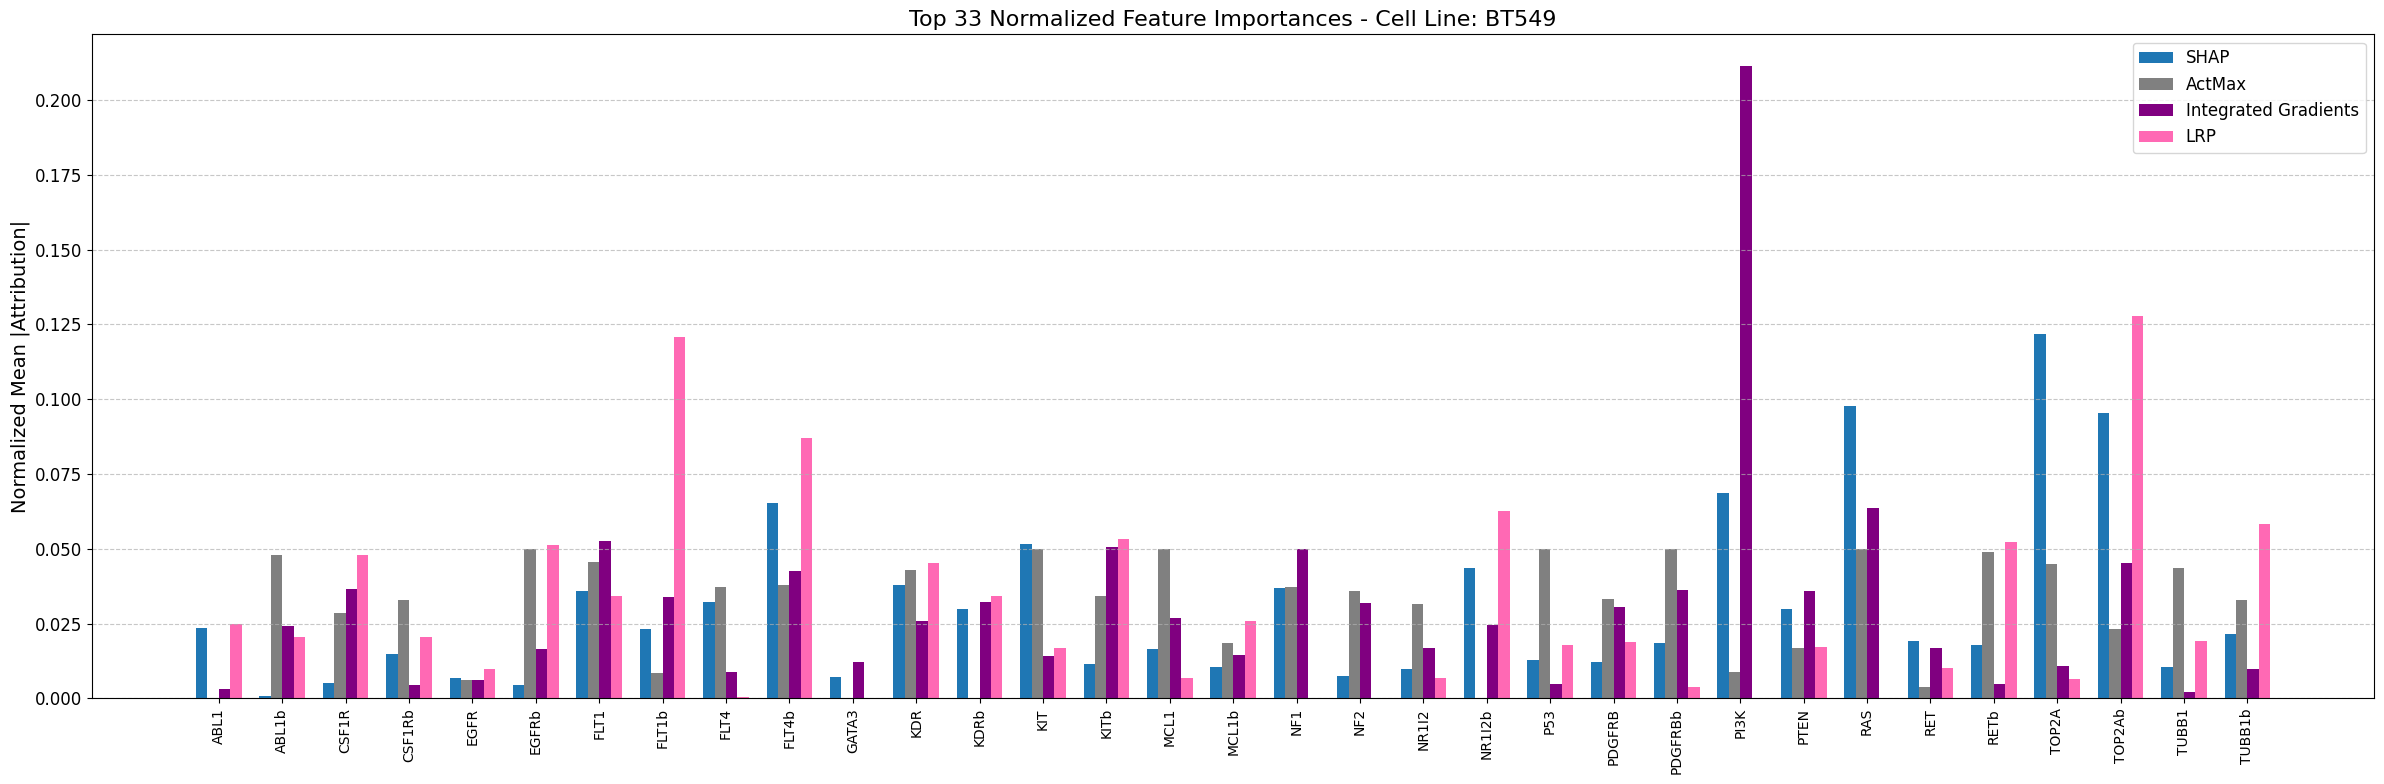

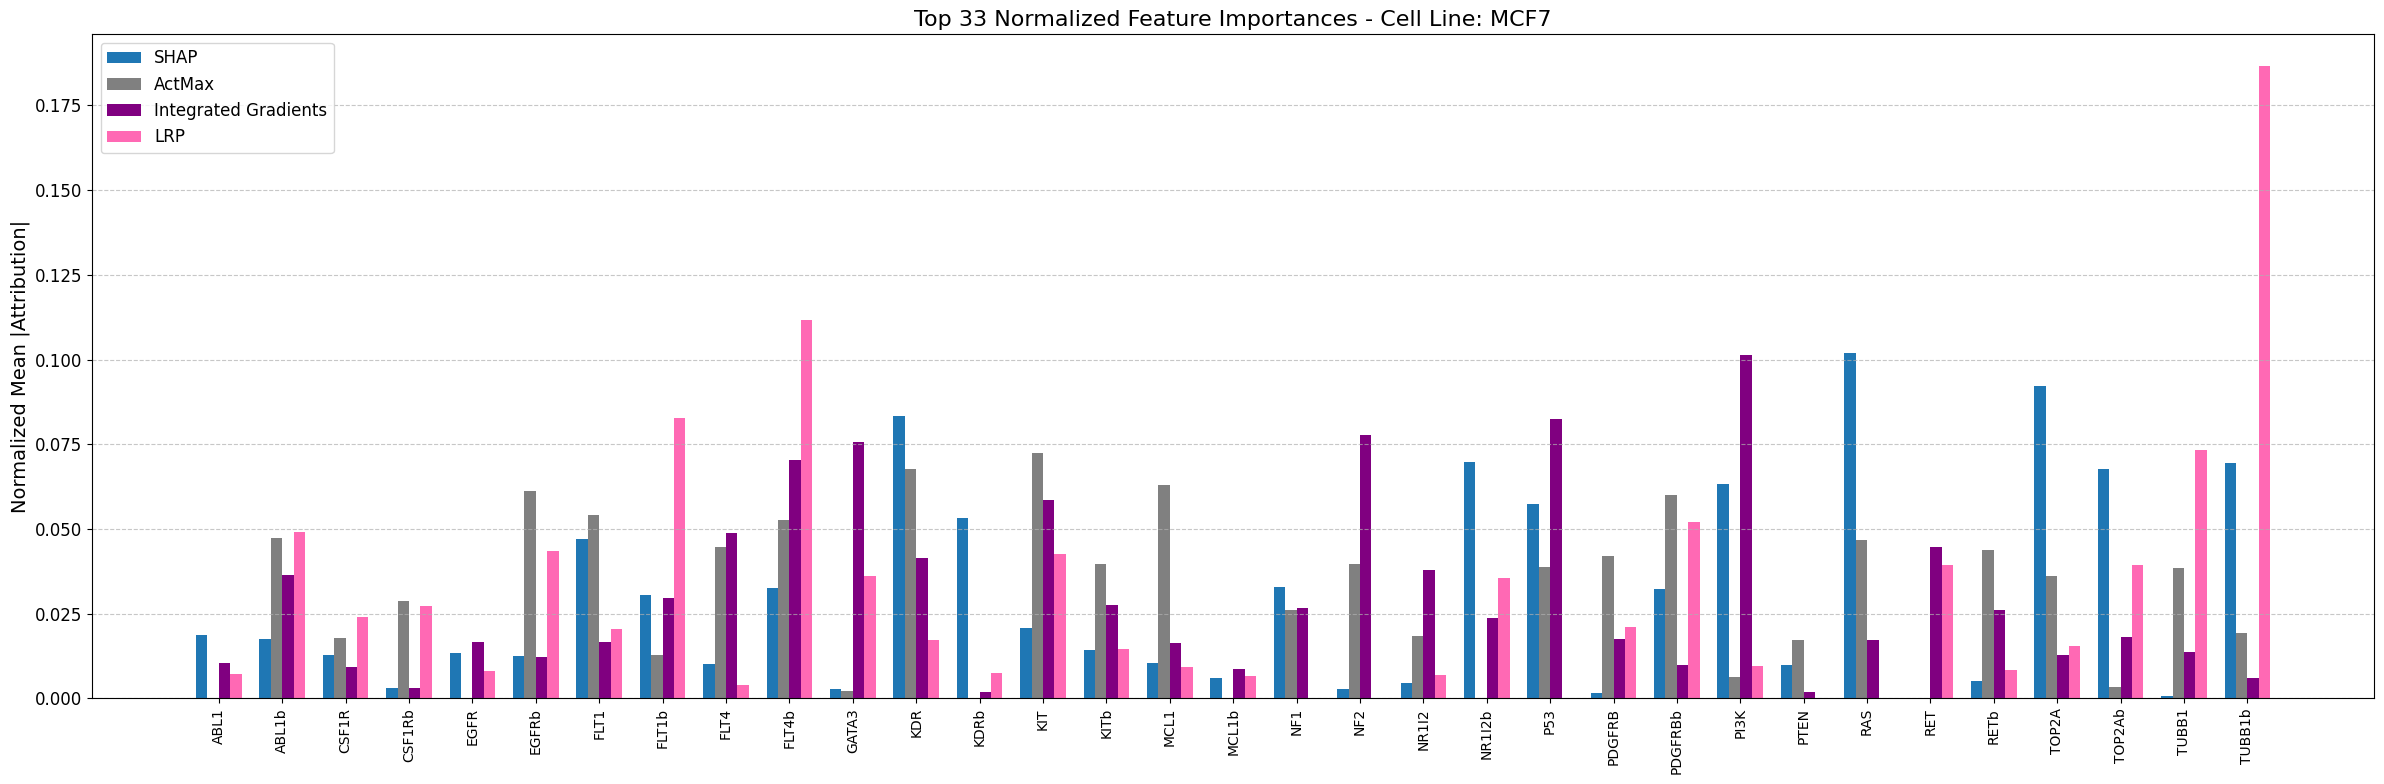

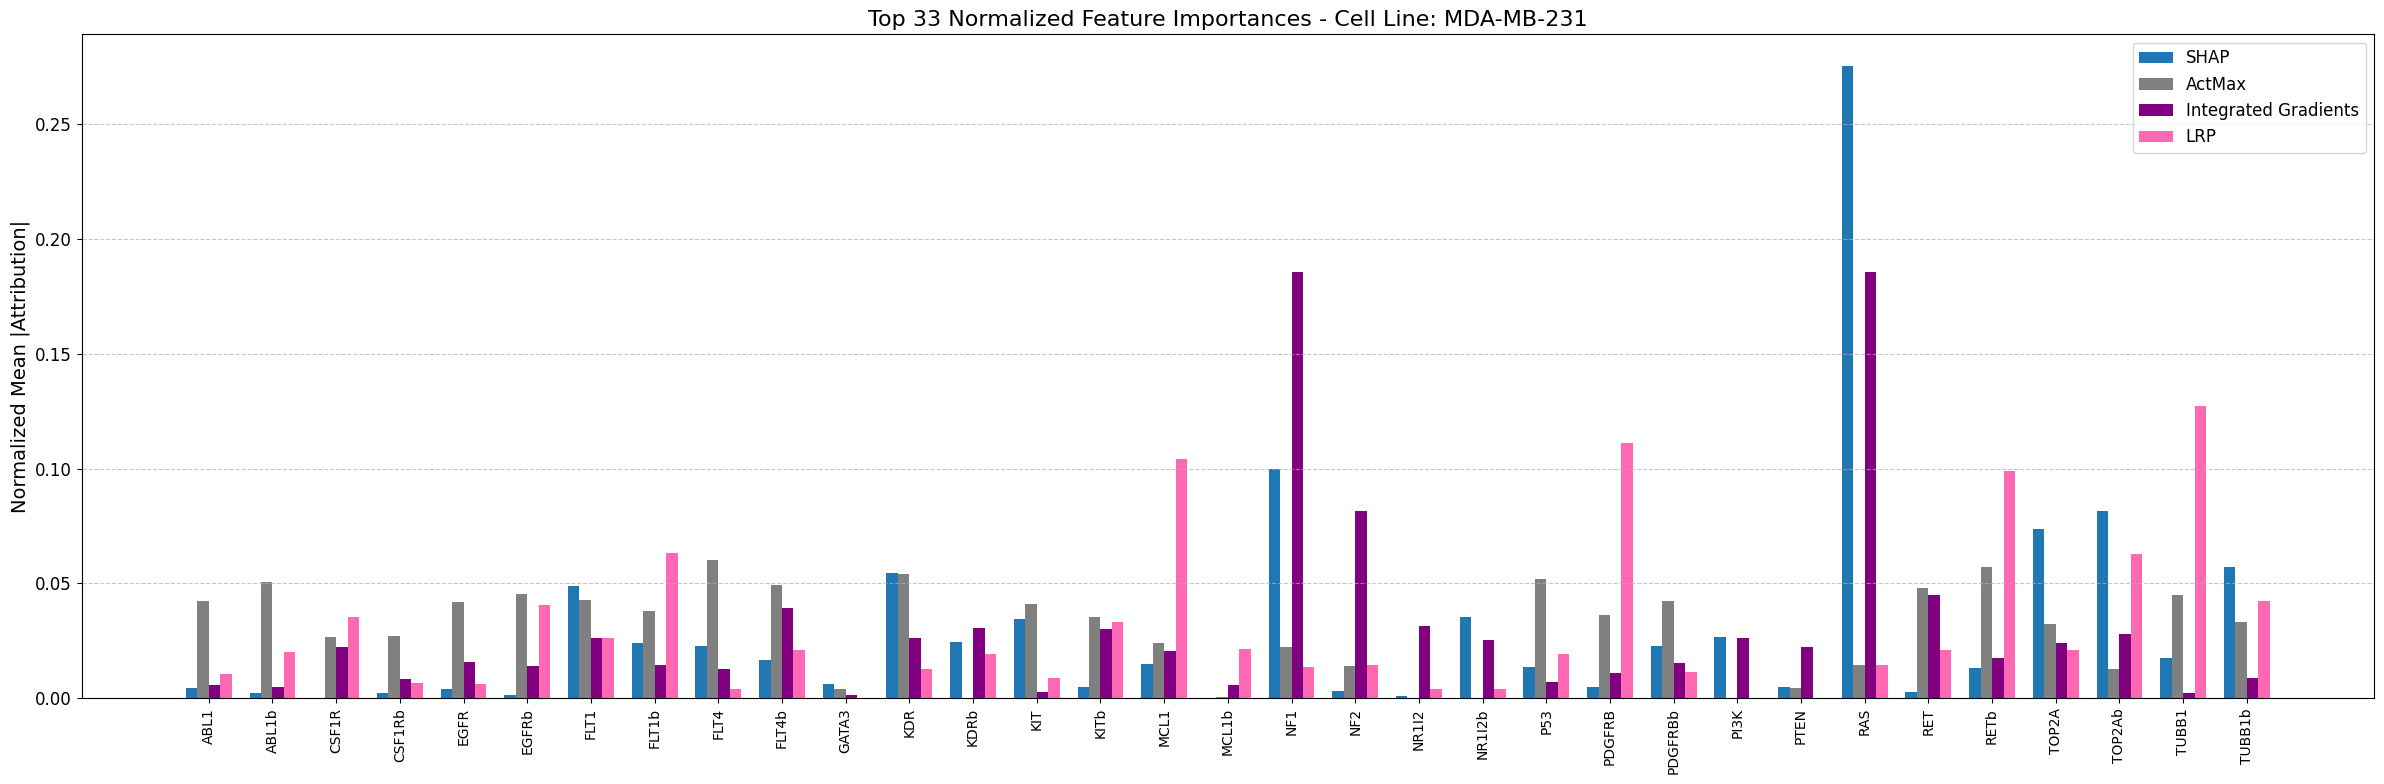

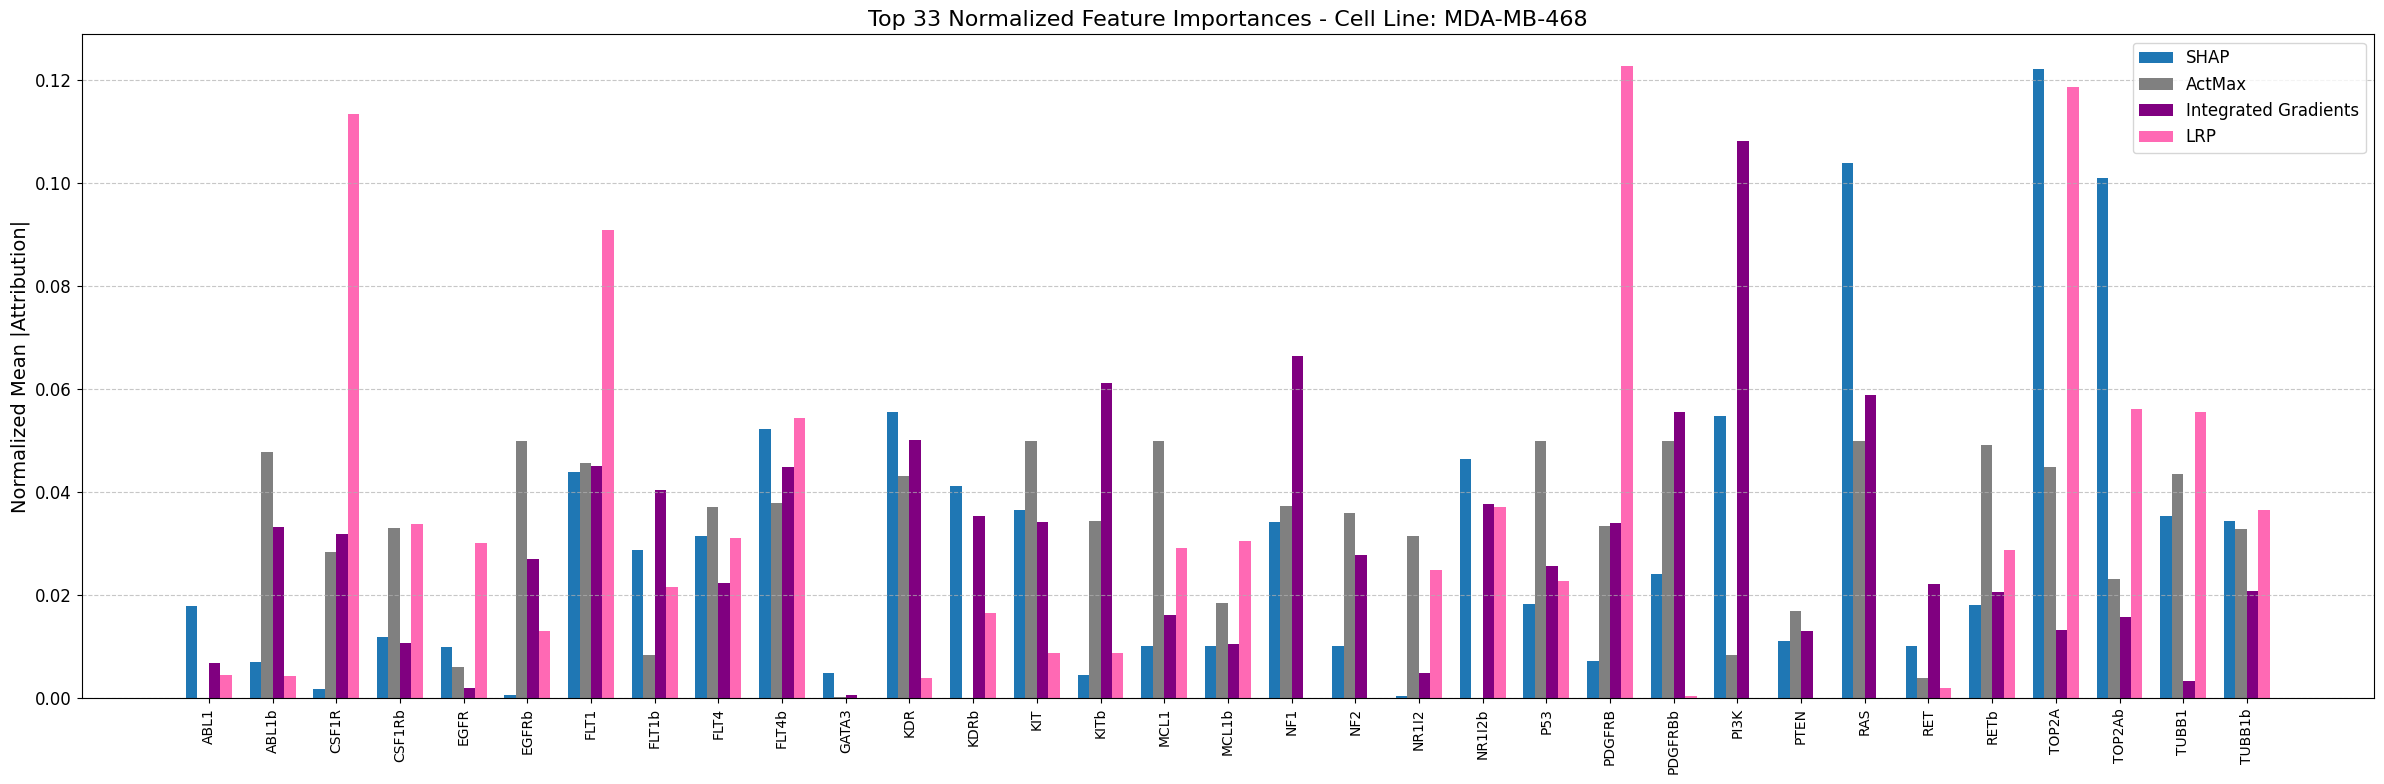

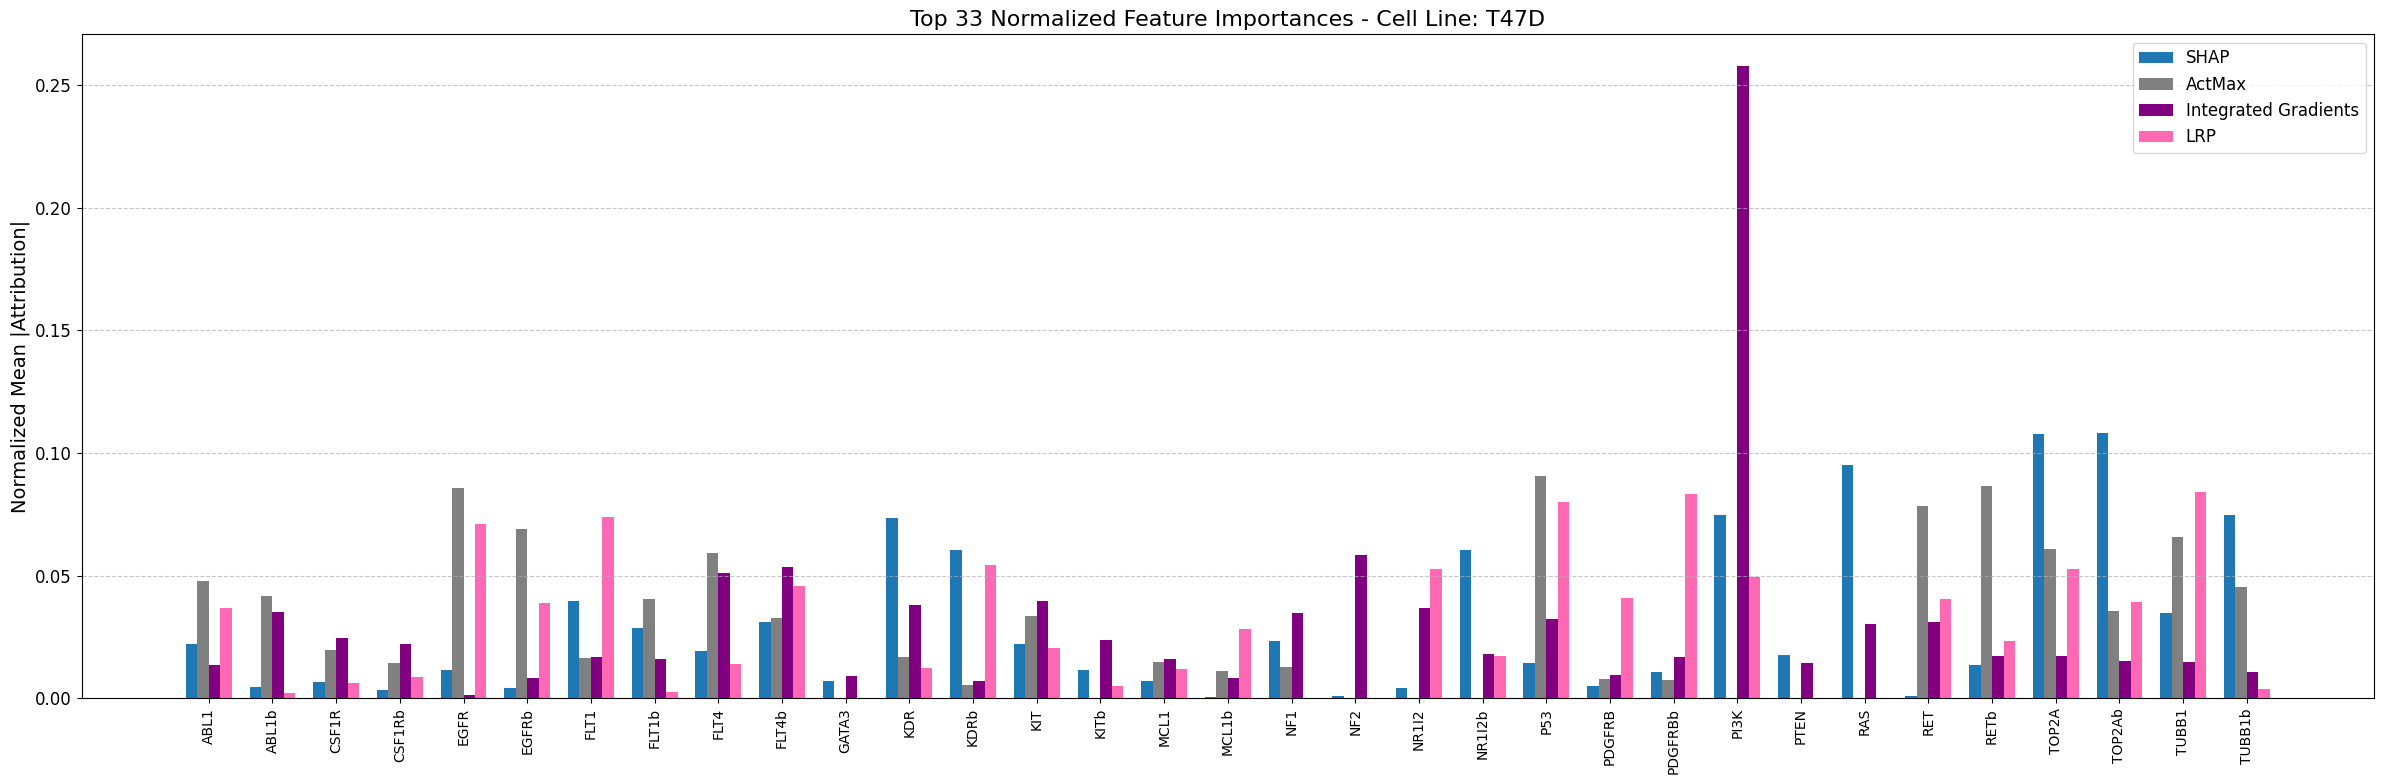

In [36]:
from explainability.data_utils import load_biomining_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def normalize_and_rescale_for_indices(attributions, indices):
    mean_vals = np.mean(attributions[indices], axis=0)
    mean_abs = np.abs(mean_vals)
    normed = mean_abs / np.sum(mean_abs)
    return normed / np.max(normed)

def plot_feature_importance_by_cell_line(shap_values, lrp_values, ig_values, feature_names, top_n=33):
    cell_lines_test = load_biomining_cell_line_data(split='test')
    cell_lines_test = np.concatenate([cell_lines_test, cell_lines_test], axis=0)
    cell_lines_train = load_biomining_cell_line_data(split='train')

    unique_test_cell_lines = np.unique(cell_lines_test)

    for cell_line in unique_test_cell_lines:
        shap_idx = np.where(cell_lines_test == cell_line)[0]
        lrp_idx = shap_idx
        ig_idx = np.where(cell_lines_train == cell_line)[0]

        am_vector = load_am_results_by_cell_line(
            paper="biomining",
            cell_line=cell_line,
            regularization="l2_input"
        )
        shap_imp = np.abs(np.mean(shap_values[shap_idx], axis=0))
        lrp_imp = np.abs(np.mean(lrp_values[lrp_idx], axis=0))
        ig_imp = np.abs(np.mean(ig_values[ig_idx], axis=0))
        am_norm = np.abs(am_vector)

        # normalize all so their AUC = 1
        shap_imp /= np.sum(np.abs(shap_imp))
        lrp_imp /= np.sum(np.abs(lrp_imp))
        ig_imp   /= np.sum(np.abs(ig_imp))
        am_norm  /= np.sum(np.abs(am_norm))


        df = pd.DataFrame({
            "feature": feature_names,
            "SHAP": shap_imp,
            "LRP": lrp_imp,
            "Integrated Gradients": ig_imp,
            "ActMax": am_norm
        })

        df["avg"] = df[["SHAP", "LRP", "Integrated Gradients", "ActMax"]].mean(axis=1)
        top_features = df.sort_values("avg", ascending=False).head(top_n)
        top_features = top_features.sort_values("feature")

        x = np.arange(top_n)
        width = 0.18
        fig, ax = plt.subplots(figsize=(24, 8))

        methods = ['SHAP', 'ActMax', 'Integrated Gradients', 'LRP']
        colors = ['#1f77b4', 'gray', 'purple', 'hotpink']

        for i, method in enumerate(methods):
            ax.bar(x + (i - 1.5) * width, top_features[method], width, label=method, color=colors[i])

        ax.set_xticks(x)
        ax.set_xticklabels(top_features["feature"], rotation=90)
        ax.set_ylabel("Normalized Mean |Attribution|")
        ax.set_title(f"Top {top_n} Normalized Feature Importances - Cell Line: {cell_line}")
        ax.legend()
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Usage
plot_feature_importance_by_cell_line(
    shap_values=shap_values,
    lrp_values=lrp_values,
    ig_values=ig_values,
    feature_names=feature_names
)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
from explainability.data_utils import load_biomining_cell_line_data

def top_k_jaccard(a, b, k=10):
    top_a = set(np.argsort(np.abs(a))[-k:])
    top_b = set(np.argsort(np.abs(b))[-k:])
    return len(top_a & top_b) / k

def compute_similarity_metrics_per_cell_line(shap_values, lrp_values, ig_values, feature_names, k=10):
    cell_lines_test = np.concatenate([
        load_biomining_cell_line_data(split='test'),
        load_biomining_cell_line_data(split='test')
    ])
    cell_lines_train = load_biomining_cell_line_data(split='train')
    unique_cell_lines = np.unique(cell_lines_test)

    results = []

    for cell_line in unique_cell_lines:
        shap_idx = np.where(cell_lines_test == cell_line)[0]
        lrp_idx = shap_idx
        ig_idx = np.where(cell_lines_train == cell_line)[0]
        
        shap_mean = np.mean(shap_values[shap_idx], axis=0)
        lrp_mean = np.mean(lrp_values[lrp_idx], axis=0)
        ig_mean = np.mean(ig_values[ig_idx], axis=0)
        am_vector = load_am_results_by_cell_line(
            paper="biomining",
            cell_line=cell_line,
            regularization="l2_input"
        )
        
        # Spearman correlation
        s_ig_corr, _ = spearmanr(shap_mean, ig_mean)
        s_lrp_corr, _ = spearmanr(shap_mean, lrp_mean)
        ig_lrp_corr, _ = spearmanr(ig_mean, lrp_mean)
        s_am_corr, _ = spearmanr(shap_mean, am_vector)
        lrp_corr_am, _ = spearmanr(am_vector, lrp_mean)
        ig_corr_am, _ = spearmanr(am_vector, ig_mean)

        # Cosine similarity
        cos_s_ig = cosine_similarity([shap_mean], [ig_mean])[0][0]
        cos_s_lrp = cosine_similarity([shap_mean], [lrp_mean])[0][0]
        cos_ig_lrp = cosine_similarity([ig_mean], [lrp_mean])[0][0]
        cos_s_am = cosine_similarity([shap_mean], [am_vector])[0][0]
        cos_lrp_am = cosine_similarity([lrp_mean], [am_vector])[0][0]
        cos_ig_am = cosine_similarity([ig_mean], [am_vector])[0][0]
        
        # Top-k Jaccard overlap
        jac_s_ig = top_k_jaccard(shap_mean, ig_mean, k)
        jac_s_lrp = top_k_jaccard(shap_mean, lrp_mean, k)
        jac_ig_lrp = top_k_jaccard(ig_mean, lrp_mean, k)
        jac_s_am = top_k_jaccard(shap_mean, am_vector, k)
        jac_lrp_am = top_k_jaccard(lrp_mean, am_vector, k)
        jac_ig_am = top_k_jaccard(ig_mean, am_vector, k
        )
        results.append({
            "cell_line": cell_line,
            "spearman_shap_ig": s_ig_corr,
            "spearman_shap_lrp": s_lrp_corr,
            "spearman_ig_lrp": ig_lrp_corr,
            "cosine_shap_ig": cos_s_ig,
            "cosine_shap_lrp": cos_s_lrp,
            "cosine_ig_lrp": cos_ig_lrp,
            "jaccard_shap_ig": jac_s_ig,
            "jaccard_shap_lrp": jac_s_lrp,
            "jaccard_ig_lrp": jac_ig_lrp,
            "spearman_shap_am": s_am_corr,
            "spearman_lrp_am": lrp_corr_am,
            "spearman_ig_am": ig_corr_am,
            "cosine_shap_am": cos_s_am,
            "cosine_lrp_am": cos_lrp_am,
            "cosine_ig_am": cos_ig_am,
            "jaccard_shap_am": jac_s_am,
            "jaccard_lrp_am": jac_lrp_am,
            "jaccard_ig_am": jac_ig_am
        })

    return pd.DataFrame(results)

similarity_df = compute_similarity_metrics_per_cell_line(
    shap_values, lrp_values, ig_values, feature_names, k=10
)
print(similarity_df.head())


    cell_line  spearman_shap_ig  spearman_shap_lrp  spearman_ig_lrp  \
0       BT549         -0.138035           0.399398        -0.333445   
1        MCF7         -0.165107           0.157349        -0.334115   
2  MDA-MB-231          0.059826           0.147108        -0.134738   
3  MDA-MB-468         -0.165107           0.005699        -0.054303   
4        T47D         -0.250000           0.199866        -0.208906   

   cosine_shap_ig  cosine_shap_lrp  cosine_ig_lrp  jaccard_shap_ig  \
0        0.134480         0.423872      -0.259763              0.6   
1       -0.291118         0.264224      -0.228612              0.3   
2        0.685061         0.103027      -0.031748              0.4   
3        0.026616         0.075343       0.016900              0.6   
4       -0.301358         0.118406      -0.234459              0.2   

   jaccard_shap_lrp  jaccard_ig_lrp  spearman_shap_am  spearman_lrp_am  \
0               0.4             0.4          0.031145         0.197920   
1   

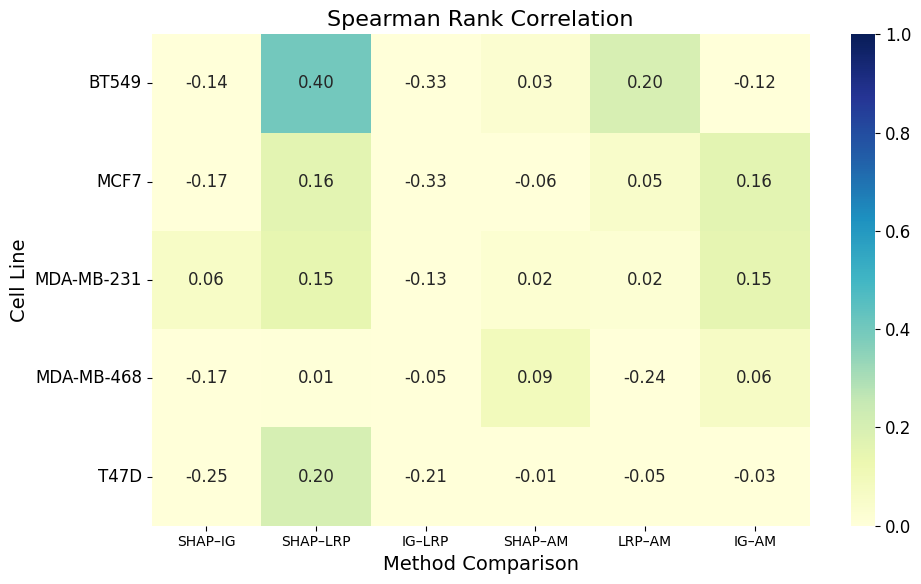

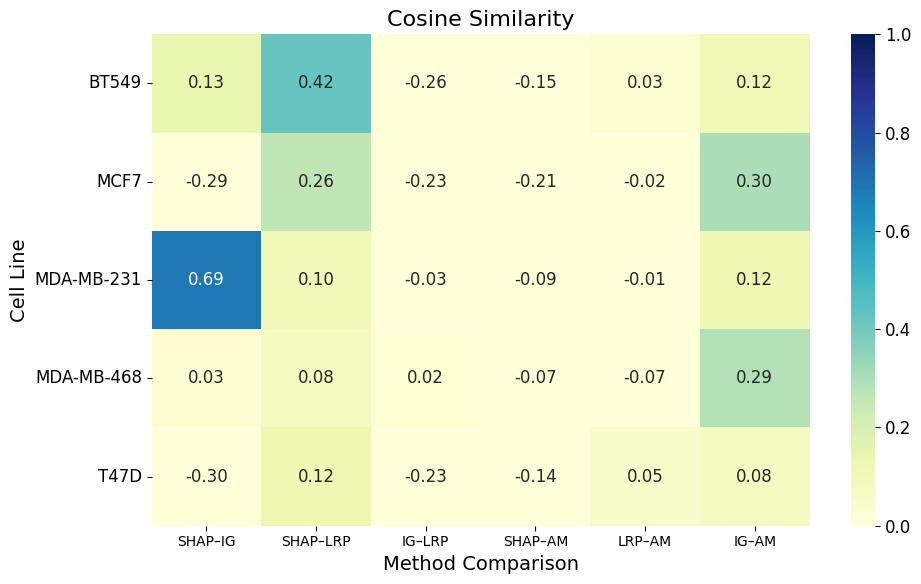

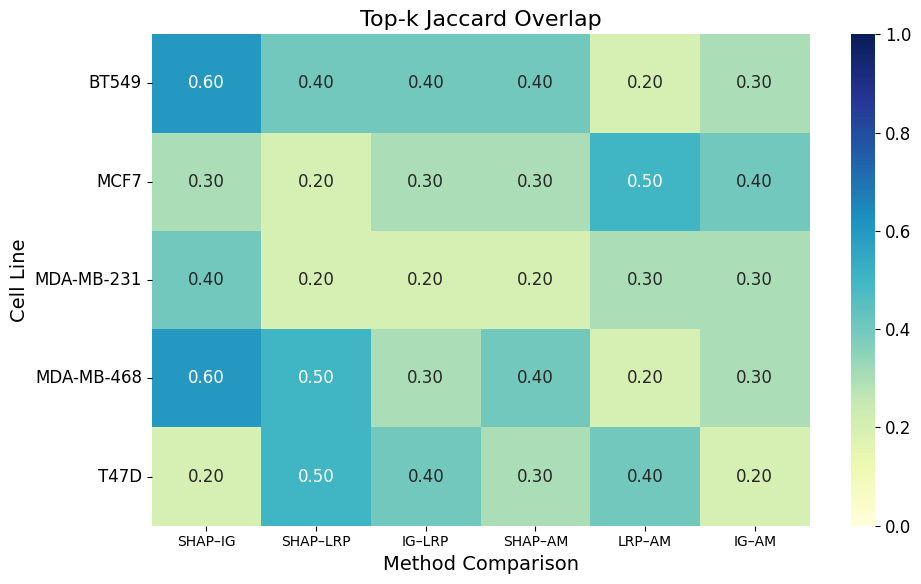

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity_heatmaps(similarity_df):
    cell_lines = similarity_df["cell_line"]
    metric_map = {
        "Spearman Rank Correlation": ["spearman_shap_ig", "spearman_shap_lrp", "spearman_ig_lrp", "spearman_shap_am", "spearman_lrp_am", "spearman_ig_am"],
        "Cosine Similarity": ["cosine_shap_ig", "cosine_shap_lrp", "cosine_ig_lrp", "cosine_shap_am", "cosine_lrp_am", "cosine_ig_am"],
        "Top-k Jaccard Overlap": ["jaccard_shap_ig", "jaccard_shap_lrp", "jaccard_ig_lrp", "jaccard_shap_am", "jaccard_lrp_am", "jaccard_ig_am"],
    }

    for title, cols in metric_map.items():
        data = similarity_df[cols]
        data.index = cell_lines
        data.columns = ["SHAP–IG", "SHAP–LRP", "IG–LRP", "SHAP–AM", "LRP–AM", "IG–AM"]
        plt.figure(figsize=(10, max(6, 0.4 * len(cell_lines))))
        sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1, cbar=True)
        plt.title(title)
        plt.xlabel("Method Comparison")
        plt.ylabel("Cell Line")
        plt.tight_layout()
        plt.show()

plot_similarity_heatmaps(similarity_df)



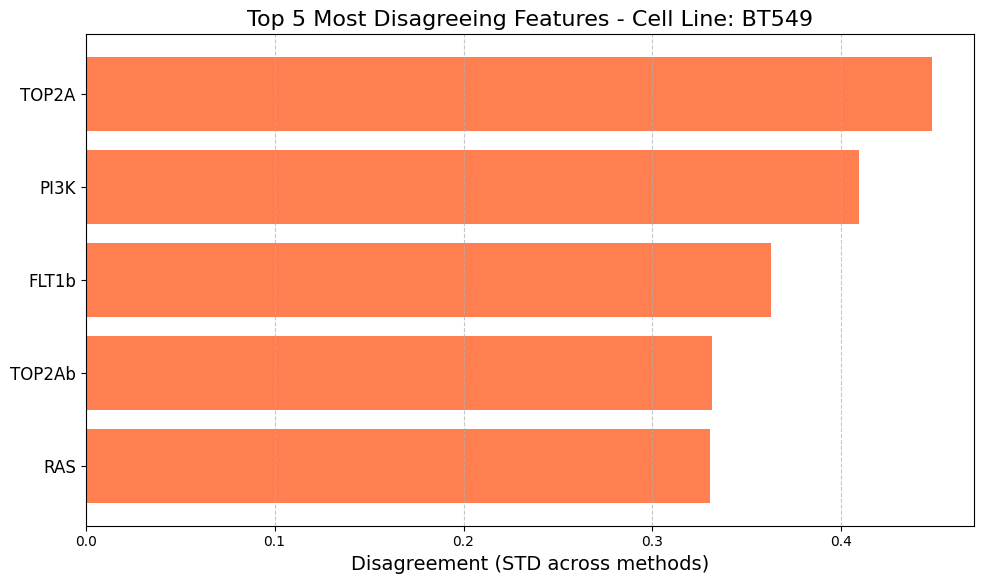

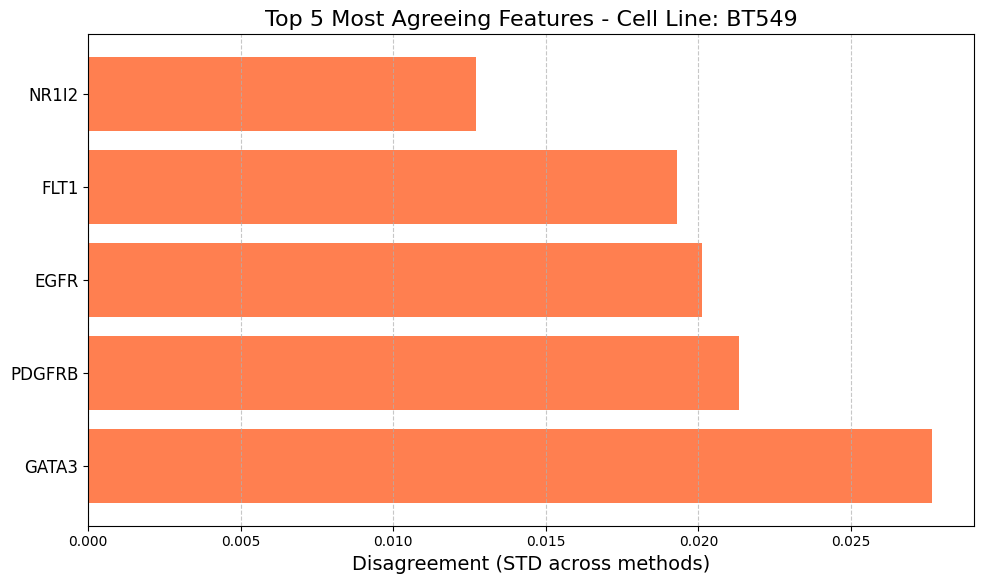

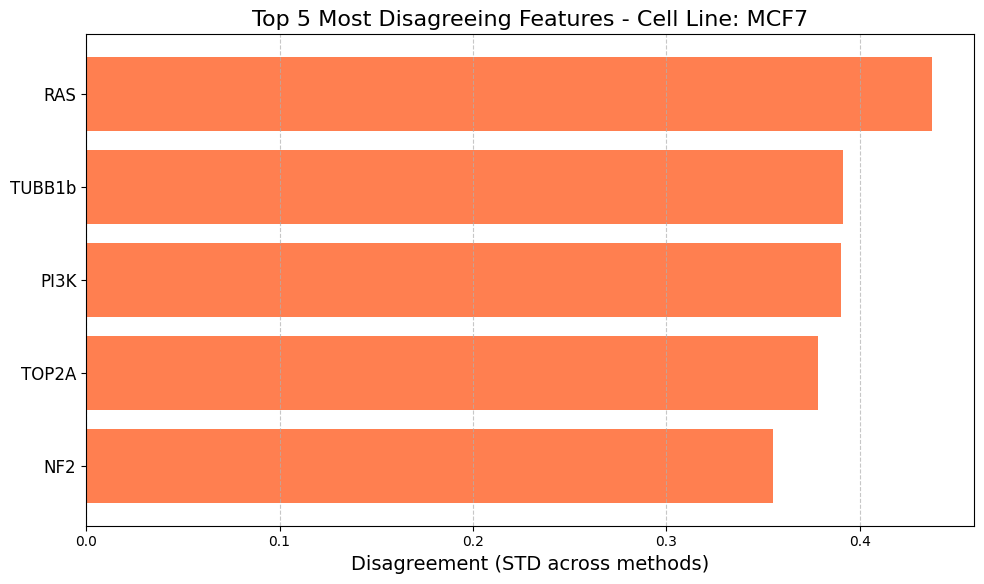

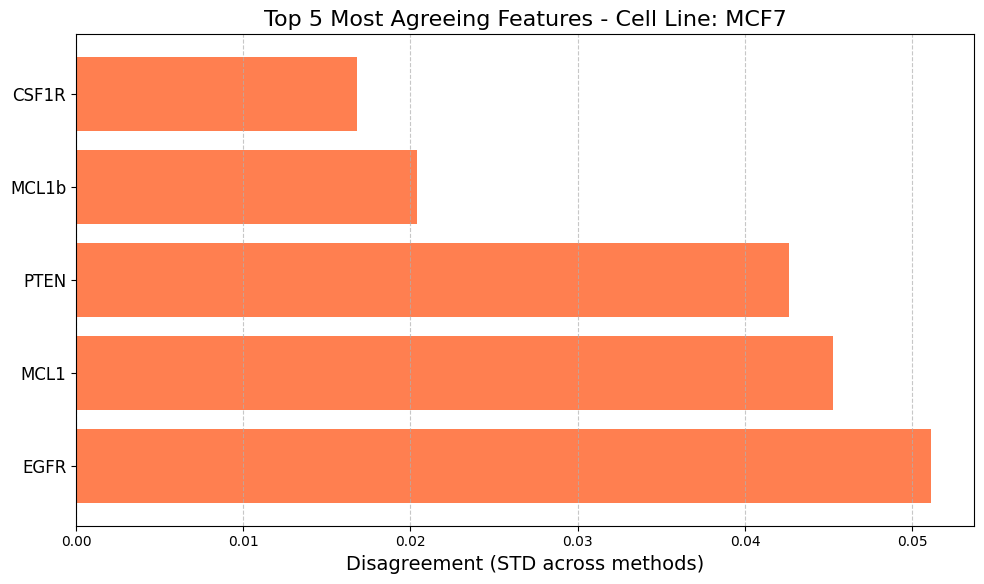

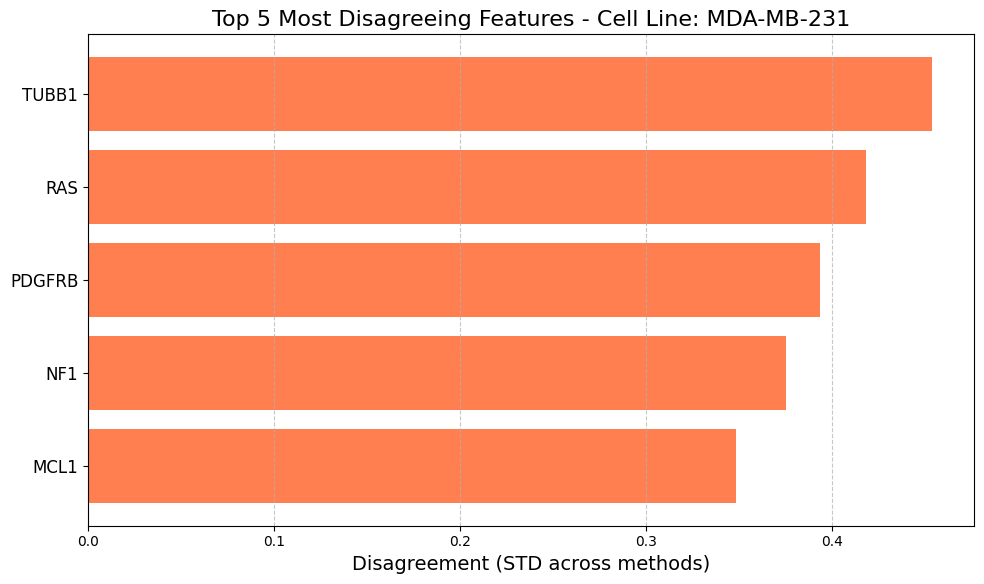

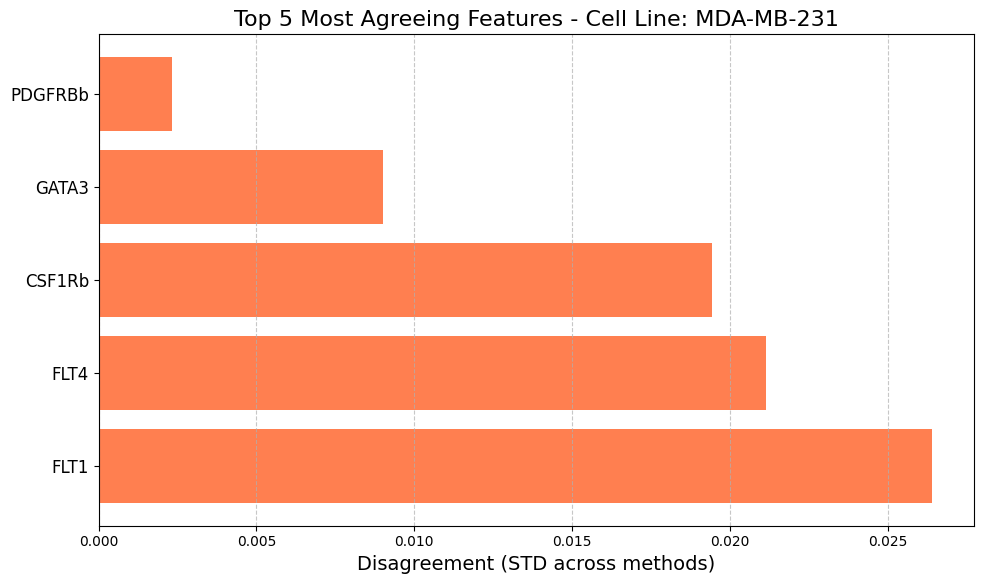

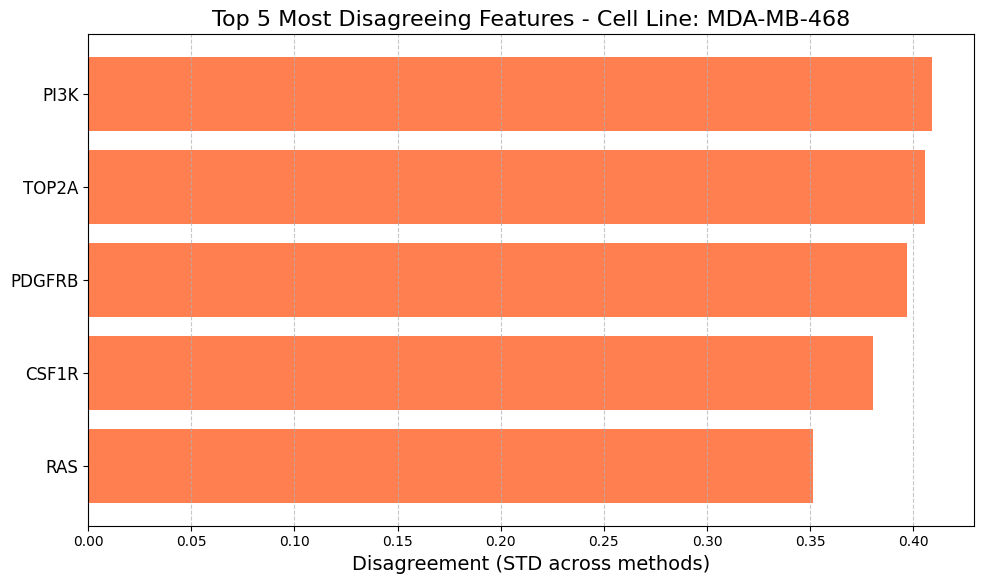

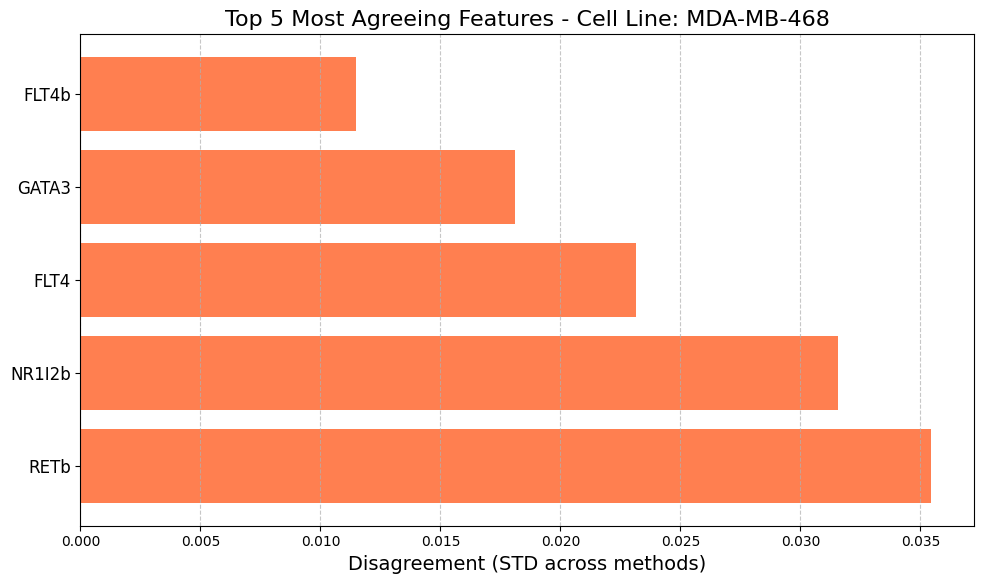

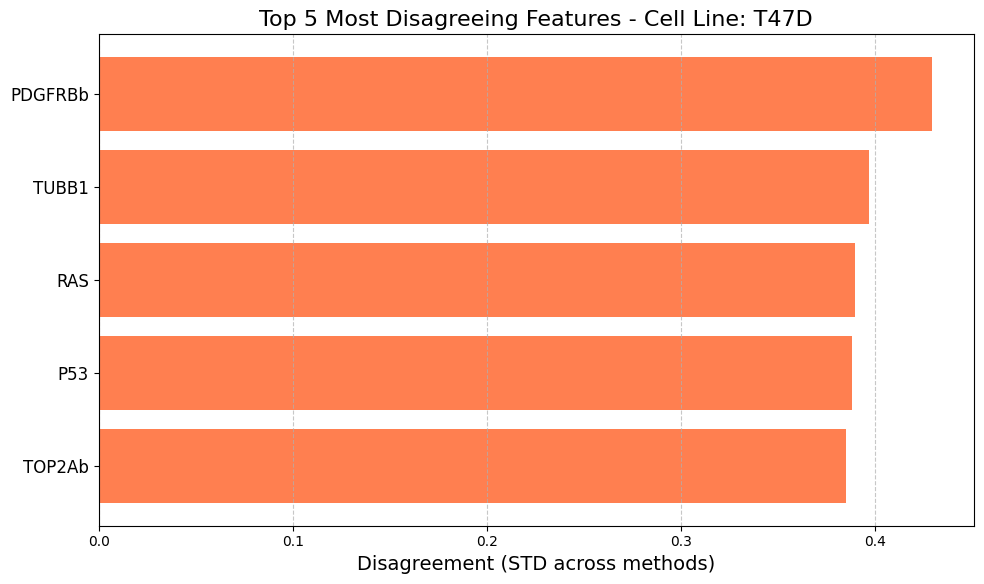

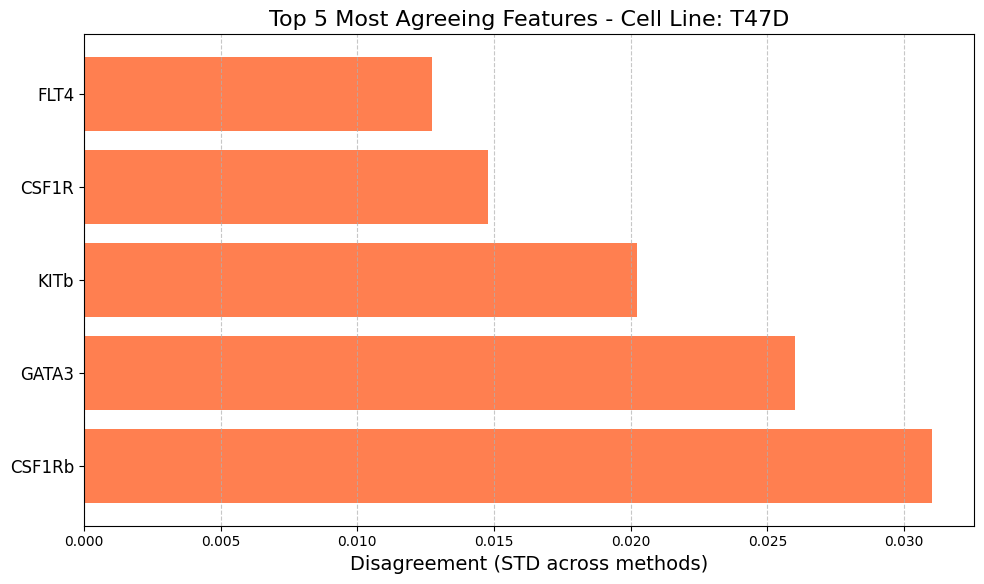

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from explainability.data_utils import load_biomining_cell_line_data

def normalize_and_rescale_for_indices(attributions, indices):
    mean_vals = np.mean(attributions[indices], axis=0)  
    mean_abs = np.abs(mean_vals)  
    normed = mean_abs / np.sum(mean_abs)  
    return normed / np.max(normed) 

def plot_disagreement_barplot(df, title, top_n=10):
    plt.figure(figsize=(10, 6))
    plt.barh(df["feature"], df["disagreement"], color='coral')
    plt.xlabel("Disagreement (STD across methods)")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def rank_feature_disagreement_by_cell_line_with_plot(shap_values, lrp_values, ig_values, feature_names, top_n=10):
    cell_lines_test = np.concatenate([
        load_biomining_cell_line_data(split='test'),
        load_biomining_cell_line_data(split='test')
    ])
    cell_lines_train = load_biomining_cell_line_data(split='train')
    unique_cell_lines = np.unique(cell_lines_test)

    for cell_line in unique_cell_lines:
        shap_idx = np.where(cell_lines_test == cell_line)[0]
        lrp_idx = shap_idx
        ig_idx = np.where(cell_lines_train == cell_line)[0]

        if len(ig_idx) == 0:
            continue

        shap_imp = normalize_and_rescale_for_indices(shap_values, shap_idx)
        lrp_imp = normalize_and_rescale_for_indices(lrp_values, lrp_idx)
        ig_imp = normalize_and_rescale_for_indices(ig_values, ig_idx)

        am_vector = load_am_results_by_cell_line(
            paper="biomining",
            cell_line=cell_line,
            regularization="l2_input"
        )
        
        disagreement = np.std(np.stack([shap_imp, lrp_imp, ig_imp]), axis=0)

        df = pd.DataFrame({
            "feature": feature_names,
            "disagreement": disagreement,
            "SHAP": shap_imp,
            "LRP": lrp_imp,
            "IG": ig_imp,
            "AM": am_vector
        })
        
        top_disagree = df.sort_values("disagreement", ascending=False).head(top_n)
        top_agree = df.sort_values("disagreement", ascending=True).head(top_n)

        plot_disagreement_barplot(top_disagree, f"Top {top_n} Most Disagreeing Features - Cell Line: {cell_line}", top_n)
        plot_disagreement_barplot(top_agree, f"Top {top_n} Most Agreeing Features - Cell Line: {cell_line}", top_n)

rank_feature_disagreement_by_cell_line_with_plot(
    shap_values=shap_values,
    lrp_values=lrp_values,
    ig_values=ig_values,
    feature_names=feature_names,
    top_n=5
)
